# Imports 

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")


# Configuration & Reproducibility

In [2]:
SEED = 42
BASE_PATH = "/kaggle/input/csiro-biomass"
IMG_SIZE = 224
BATCH_SIZE = 16
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Load & Pivot Dataset

In [3]:
df = pd.read_csv(os.path.join(BASE_PATH, "train.csv"))

df = df.pivot_table(
    index="image_path",
    columns="target_name",
    values="target"
).reset_index()

df.fillna(0, inplace=True)

TARGET_COLUMNS = [
    'Dry_Green_g',
    'Dry_Dead_g',
    'Dry_Clover_g',
    'GDM_g',
    'Dry_Total_g'
]

print("Dataset shape:", df.shape)


Dataset shape: (357, 6)


# Train / Validation Split & Target Scaling

In [4]:
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=SEED,
    shuffle=True
)

scaler = StandardScaler()
scaler.fit(train_df[TARGET_COLUMNS].values)


StandardScaler()

# Dataset Class

In [5]:
class BiomassDataset(Dataset):
    def __init__(self, df, image_dir, transform=None, scaler=None):
        self.df = df.copy()
        self.df["image_path"] = self.df["image_path"].apply(os.path.basename)
        self.samples = list(self.df.itertuples(index=False))
        self.image_dir = image_dir
        self.transform = transform
        self.scaler = scaler

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        row = self.samples[idx]
        img = Image.open(
            os.path.join(self.image_dir, row.image_path)
        ).convert("RGB")

        if self.transform:
            img = self.transform(img)

        target = np.array(
            [getattr(row, t) for t in TARGET_COLUMNS],
            dtype=np.float32
        )

        if self.scaler:
            target = self.scaler.transform(target.reshape(1, -1))[0]

        return img, torch.tensor(target)


# Augmentation Strategies 

In [6]:
augmentation_configs = {
    "no_aug": transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),

    "light_aug": transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),

    "medium_aug": transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(0.2,0.2,0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),

    "strong_aug": transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.3),
        transforms.RandomRotation(25),
        transforms.ColorJitter(0.3,0.3,0.3,0.05),
        transforms.RandomAffine(0, translate=(0.1,0.1), scale=(0.9,1.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
}


# Fixed Validation Transform

In [7]:
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


# Weighted Loss 

In [8]:
TARGET_WEIGHTS = torch.tensor([0.1,0.1,0.1,0.2,0.5], device=DEVICE)

class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super().__init__()
        self.register_buffer("weights", weights)

    def forward(self, preds, targets):
        return ((preds - targets) ** 2 * self.weights).mean()

criterion = WeightedMSELoss(TARGET_WEIGHTS)


# Weighted R² Metric

In [9]:
def weighted_r2_score(y_true, y_pred, weights):
    mean_y = y_true.mean(0, keepdim=True)
    ss_res = ((y_true - y_pred)**2).sum(0)
    ss_tot = ((y_true - mean_y)**2).sum(0)
    return (1 - (weights*ss_res).sum() /
            ((weights*ss_tot).sum() + 1e-8)).item()


# CNN Architecture (Fixed)

In [10]:
class CNN(nn.Module):
    def __init__(self, num_filters=256, num_blocks=3, num_outputs=5):
        super().__init__()
        layers = []
        in_channels = 3

        for _ in range(num_blocks):
            layers += [
                nn.Conv2d(in_channels, num_filters, 3, padding=1),
                nn.BatchNorm2d(num_filters),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2)
            ]
            in_channels = num_filters

        layers.append(nn.AdaptiveAvgPool2d(1))
        self.features = nn.Sequential(*layers)
        self.regressor = nn.Linear(num_filters, num_outputs)

    def forward(self, x):
        x = self.features(x)
        return self.regressor(x.flatten(1))


# One-Epoch Train / Eval Function

In [11]:
def run_epoch(model, loader, optimizer=None):
    training = optimizer is not None
    model.train() if training else model.eval()

    total_loss, total_r2, n = 0, 0, 0

    with torch.set_grad_enabled(training):
        for imgs, targets in loader:
            imgs, targets = imgs.to(DEVICE), targets.to(DEVICE)
            preds = model(imgs)
            loss = criterion(preds, targets)

            if training:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            b = imgs.size(0)
            total_loss += loss.item() * b
            total_r2 += weighted_r2_score(
                targets, preds, TARGET_WEIGHTS
            ) * b
            n += b

    return total_loss/n, total_r2/n


# Augmentation Experiment Training Loop

In [12]:
results = {}

for aug_name, train_tf in augmentation_configs.items():
    print(f"\n==============================")
    print(f" Augmentation: {aug_name}")
    print(f"==============================")

    train_dataset = BiomassDataset(
        train_df, os.path.join(BASE_PATH,"train"),
        transform=train_tf, scaler=scaler
    )

    val_dataset = BiomassDataset(
        val_df, os.path.join(BASE_PATH,"train"),
        transform=val_transform, scaler=scaler
    )

    train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, BATCH_SIZE, shuffle=False, num_workers=2)

    model = CNN().to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    train_losses, val_losses = [], []
    train_r2s, val_r2s = [], []
    best_val_r2 = -1e9

    for epoch in range(NUM_EPOCHS):
        tr_l, tr_r2 = run_epoch(model, train_loader, optimizer)
        va_l, va_r2 = run_epoch(model, val_loader)

        train_losses.append(tr_l)
        val_losses.append(va_l)
        train_r2s.append(tr_r2)
        val_r2s.append(va_r2)

        best_val_r2 = max(best_val_r2, va_r2)

        print(
            f"Epoch {epoch+1} | "
            f"Train R²: {tr_r2:.4f} | "
            f"Val R²: {va_r2:.4f}"
        )

    results[aug_name] = {
        "avg_train_r2": np.mean(train_r2s),
        "avg_val_r2": np.mean(val_r2s),
        "best_val_r2": best_val_r2,
        "avg_val_loss": np.mean(val_losses),
        "val_r2s": val_r2s
    }



 Augmentation: no_aug
Epoch 1 | Train R²: -0.1831 | Val R²: -2.8216
Epoch 2 | Train R²: 0.0664 | Val R²: -0.0146
Epoch 3 | Train R²: 0.1576 | Val R²: 0.0411
Epoch 4 | Train R²: 0.1791 | Val R²: -0.1129
Epoch 5 | Train R²: 0.1808 | Val R²: 0.1225
Epoch 6 | Train R²: 0.0082 | Val R²: 0.0704
Epoch 7 | Train R²: 0.2041 | Val R²: 0.2345
Epoch 8 | Train R²: 0.1555 | Val R²: 0.1686
Epoch 9 | Train R²: 0.2101 | Val R²: 0.0803
Epoch 10 | Train R²: 0.1847 | Val R²: 0.0706
Epoch 11 | Train R²: 0.2255 | Val R²: -0.0399
Epoch 12 | Train R²: 0.1173 | Val R²: 0.0882
Epoch 13 | Train R²: 0.3186 | Val R²: 0.2098
Epoch 14 | Train R²: 0.2740 | Val R²: -0.9007
Epoch 15 | Train R²: 0.1864 | Val R²: -0.1540
Epoch 16 | Train R²: 0.2818 | Val R²: 0.1656
Epoch 17 | Train R²: 0.2715 | Val R²: 0.0951
Epoch 18 | Train R²: 0.2243 | Val R²: 0.2388
Epoch 19 | Train R²: 0.2616 | Val R²: 0.0219
Epoch 20 | Train R²: 0.2633 | Val R²: 0.2370

 Augmentation: light_aug
Epoch 1 | Train R²: -0.4480 | Val R²: -1.5534
Epoch 2

# Summary Table

In [13]:
summary_df = pd.DataFrame([
    {
        "Augmentation": k,
        "Avg Val R²": results[k]["avg_val_r2"],
        "Best Val R²": results[k]["best_val_r2"],
        "Avg Val Loss": results[k]["avg_val_loss"]
    }
    for k in results
]).sort_values("Avg Val R²", ascending=False)

display(summary_df)


,Augmentation,Avg Val R²,Best Val R²,Avg Val Loss
2,medium_aug,0.112023,0.222104,0.120532
3,strong_aug,0.044965,0.166239,0.131189
1,light_aug,0.022247,0.245681,0.127315
0,no_aug,-0.109971,0.238753,0.140283


# Validation R² Plot

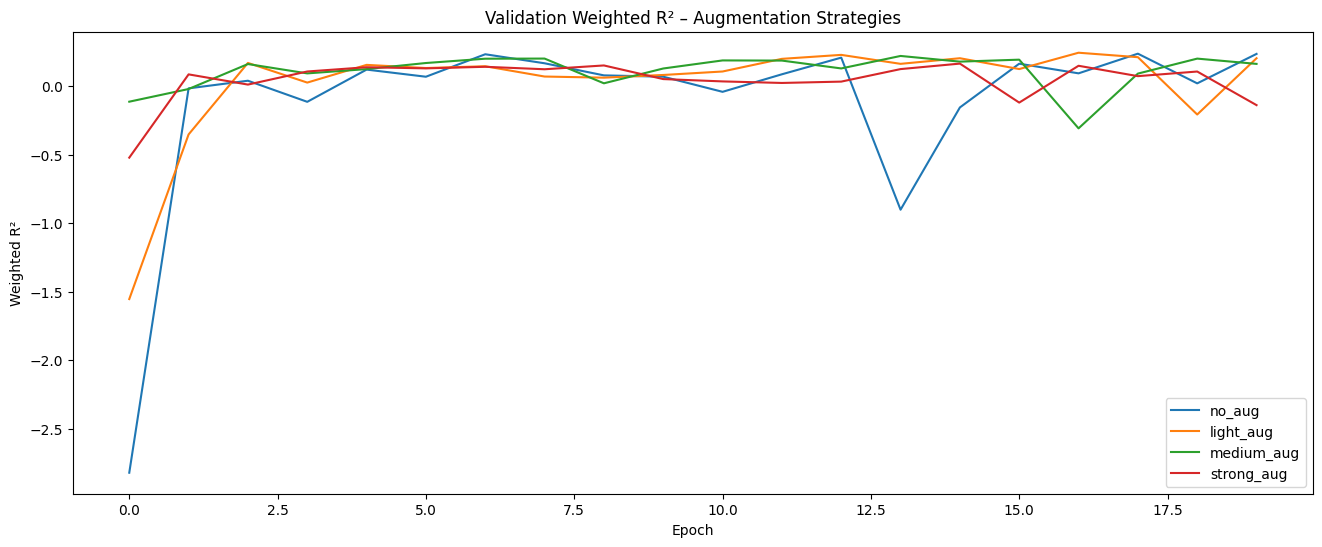

In [14]:
plt.figure(figsize=(16,6))
for k in results:
    plt.plot(results[k]["val_r2s"], label=k)
plt.title("Validation Weighted R² – Augmentation Strategies")
plt.xlabel("Epoch")
plt.ylabel("Weighted R²")
plt.legend()
plt.show()
